In [1]:
# -*- coding: utf-8 -*-
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.linear_model import Lasso    #Regressão Linear com L1
from sklearn.model_selection import train_test_split


#Função que recebe os Ys calculados pela regressão, que são os Percents, e os Ys reais que são os PL (perdas/lucros) de cada aposta
def SomaLog(Percent,PL):
    MIN_BANCA,MAX_BANCA= 0.01, 0.1
    return sum((MAX_BANCA if p>MAX_BANCA else p)*pl for p,pl in zip(Percent,PL) if p>=MIN_BANCA )



#Le o csv e filtra as colunas que serão utilizadas
df=pd.read_csv('../input/jogos_.csv')
df=df['s_g,s_c,s_da,s_s,s_r,d_g,d_c,d_da,d_s,goal,goal_diff,oddsU,probU,probU_diff,mod0,mod25,mod50,mod75,pl_u'.split(',')]

#Remove as linhas estão NaN, (preguiça de procurar, mas como é só um exemplo de uso tudo bem)
df.dropna(inplace=True)

#Mostra as 5 primeiras linhas
df.head(5)

,s_g,s_c,s_da,s_s,s_r,d_g,d_c,d_da,d_s,goal,goal_diff,oddsU,probU,probU_diff,mod0,mod25,mod50,mod75,pl_u
0,0.0,6.0,54.0,8.0,0.0,0.0,4.0,12.0,6.0,1.25,1.25,1.925,0.493421,0.006579,0.0,1.0,0.0,0.0,0.4625
1,0.0,2.0,66.0,6.0,0.0,0.0,2.0,10.0,4.0,1.25,1.25,1.950,0.486842,0.013158,0.0,1.0,0.0,0.0,-1.0000
2,1.0,8.0,34.0,9.0,0.0,1.0,8.0,0.0,3.0,2.50,1.50,1.750,0.539474,0.039474,0.0,0.0,1.0,0.0,-1.0000
3,3.0,9.0,52.0,6.0,0.0,1.0,5.0,2.0,0.0,4.25,1.25,1.975,0.480263,0.019737,0.0,1.0,0.0,0.0,-1.0000
4,2.0,4.0,28.0,11.0,0.0,0.0,0.0,6.0,5.0,3.50,1.50,1.900,0.500000,0.000000,0.0,0.0,1.0,0.0,-1.0000


Vamos dividir df entre conjunto de Treinamento e Teste de forma randômica, mas fixando o tamanho entre 50 mil registros. Será escolhido um estado randômico de forma que a média do pl_u do conjunto de teste esteja bem próxima da média do conjunto de treinamento.

In [2]:
#Divide entre treinamento e teste, foi escolhi o random_state=881, pois nesse as médias de Y_train e  Y_test estão bem próximas
X_train, X_test, Y_train, Y_test = train_test_split(df.loc[:,df.columns!='pl_u'], df.pl_u, test_size=50000, random_state=881)

print('pl_medio_train:', Y_train.mean(), '\npl_medio_test: ', Y_test.mean())

pl_medio_train: -0.02396081235105205 
pl_medio_test:  -0.023993450000000093


Agora vamos fazer uma Lasso Regression com alpha=1e-4 e ver como ficam os coeficientes da equação e a lucratividade 

In [3]:
#Treinamos a regressão com alpha=1e-4  ( ou seja, 0.0001)
reg1=Lasso(alpha=1e-4).fit(X_train,Y_train)

#Exibe a equação
print(  'pl_u= '+' + '.join("{0:.6}".format(reg1.coef_[i])+'*'+col for i,col in enumerate(X_train.columns)) +" + {0:.6}".format(reg1.intercept_)  )

#Exibe a Lucratividade através do SomaLog
print( '\nSomaLog: ', SomaLog( reg1.predict(X_test), Y_test)  )

pl_u= -0.00368037*s_g + -0.00471534*s_c + -0.000271481*s_da + -0.00566365*s_s + -0.00411172*s_r + -0.0264619*d_g + -2.64171e-05*d_c + -0.000608849*d_da + -0.00124694*d_s + -0.0*goal + 0.0833661*goal_diff + 0.0545463*oddsU + -0.0*probU + -0.0*probU_diff + 0.0107895*mod0 + 0.00313165*mod25 + -7.855e-09*mod50 + -0.0139825*mod75 + -0.124249

SomaLog:  24.151040846602633


Perceba que coeficiente das colunas s_r, goal, probU e  probU_diff ficaram zerados. Lasso Regression acabou por fazer uma seleção de colunas na própria regressão linear.

Vamos vamos fazer uma nova regressão mas com alpha maior, alpha=1e-3

In [4]:
#Treinamos a regressão com alpha=1e-4  ( ou seja, 0.0001)
reg2=Lasso(alpha=1e-3).fit(X_train,Y_train)

#Exibe a equação
print(  'pl_u= '+' + '.join("{0:.6}".format(reg2.coef_[i])+'*'+col for i,col in enumerate(X_train.columns)) +" + {0:.6}".format(reg2.intercept_)  )

#Exibe a Lucratividade através do SomaLog
print( '\nSomaLog: ', SomaLog( reg2.predict(X_test), Y_test)  )

pl_u= -0.00244315*s_g + -0.00444015*s_c + -0.000274089*s_da + -0.00560466*s_s + -0.0*s_r + -0.0246188*d_g + -0.0*d_c + -0.000515509*d_da + -0.000934687*d_s + -0.0*goal + 0.0676266*goal_diff + 0.0*oddsU + -0.0*probU + -0.0*probU_diff + 0.00675451*mod0 + 0.0*mod25 + -0.0*mod50 + -0.00603782*mod75 + -0.00349185

SomaLog:  17.97597180193675


Perceba agora, que mais colunas tiveram seus coeficientes zerados. Mas a regressão ficou menos lucrativa.

Agora vamos plotar um gráfico relacionando os alphas e os Somalogs dos conjunto de teste

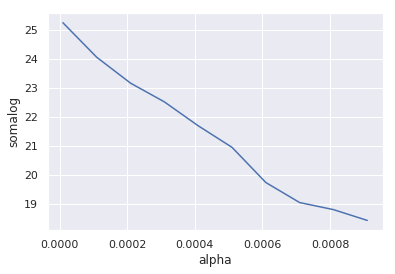

In [5]:
import seaborn as sns
sns.set(style='darkgrid')

alpha_incial=1e-5

alphas=[]
somalogs=[]
for i in range(10):
    alpha=alpha_incial+i*1e-4
    
    reg=Lasso(alpha=alpha, max_iter=5000).fit(X_train,Y_train)
    
    alphas+=[alpha]
    somalogs+=[SomaLog( reg.predict(X_test), Y_test)]

data = pd.DataFrame({'alpha': alphas, 'somalog': somalogs})

sns.lineplot(x='alpha', y='somalog', data=data)


A regularização normalmente melhora a regressão, pois diminui overfitting, entretanto se o conjunto de treinamento bem grande ( como é nosso caso), a regularização mais atrapalha do que ajuda. Pelo gráfico vemos que quanto maior o alpha, pior a lucratividade.